## 实战 Kaggle 比赛：图像分类 (CIFAR-10)

比赛的网址是 https://www.kaggle.com/c/cifar-10

In [2]:
# 下面两行是防止内核挂掉加的
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

import collections
import math
import os
import shutil
import pandas as pd
import torch
import torchvision
from torch import nn
from d2l import torch as d2l

我们提供包含前 1000 个训练图像和 5 个随机测试图像的数据集的小规模样本

In [3]:
d2l.DATA_HUB['cifar10_tiny'] = (d2l.DATA_URL + 'kaggle_cifar10_tiny.zip',
                                '2068874e4b9a9f0fb07ebe0ad2b29754449ccacd')

demo = False

if demo:
    data_dir = d2l.download_extract('cifar10_tiny')
else:
    data_dir = '../data/cifar-10/'

整理数据集:每一个类存放一个文件夹

In [4]:
def read_csv_labels(fname):
    """读取 `fname` 来给标签字典返回一个文件名。"""
    with open(fname, 'r') as f:
        lines = f.readlines()[1:]
    tokens = [l.rstrip().split(',') for l in lines]
    return dict(((name, label) for name, label in tokens))

labels = read_csv_labels(os.path.join(data_dir, 'trainLabels.csv')) # 存放训练集标签的文件
n = collections.Counter(labels.values()).most_common()[-1][1]
print(n)
labels

5000


{'1': 'frog',
 '2': 'truck',
 '3': 'truck',
 '4': 'deer',
 '5': 'automobile',
 '6': 'automobile',
 '7': 'bird',
 '8': 'horse',
 '9': 'ship',
 '10': 'cat',
 '11': 'deer',
 '12': 'horse',
 '13': 'horse',
 '14': 'bird',
 '15': 'truck',
 '16': 'truck',
 '17': 'truck',
 '18': 'cat',
 '19': 'bird',
 '20': 'frog',
 '21': 'deer',
 '22': 'cat',
 '23': 'frog',
 '24': 'frog',
 '25': 'bird',
 '26': 'frog',
 '27': 'cat',
 '28': 'dog',
 '29': 'deer',
 '30': 'airplane',
 '31': 'airplane',
 '32': 'truck',
 '33': 'automobile',
 '34': 'cat',
 '35': 'deer',
 '36': 'airplane',
 '37': 'cat',
 '38': 'horse',
 '39': 'cat',
 '40': 'cat',
 '41': 'dog',
 '42': 'bird',
 '43': 'bird',
 '44': 'horse',
 '45': 'automobile',
 '46': 'automobile',
 '47': 'automobile',
 '48': 'bird',
 '49': 'bird',
 '50': 'airplane',
 '51': 'truck',
 '52': 'dog',
 '53': 'horse',
 '54': 'truck',
 '55': 'bird',
 '56': 'bird',
 '57': 'dog',
 '58': 'bird',
 '59': 'deer',
 '60': 'cat',
 '61': 'automobile',
 '62': 'automobile',
 '63': 'ship',

将验证集从原始的训练集中拆分出来；

In [5]:
def copyfile(filename, target_dir):
    """将文件复制到目标目录。"""
    os.makedirs(target_dir, exist_ok=True)
    shutil.copy(filename, target_dir)

def reorg_train_valid(data_dir, labels, valid_ratio):
    # 下面的collections.Counter就是统计label这个字典中有几个类别（返回字典）；.most_common()则转换成元组；[-1][1]则返回最后一个元组的第二个值(因为这个类别数量最小)
    n = collections.Counter(labels.values()).most_common()[-1][1] # n就是最小类别的数量
    n_valid_per_label = max(1, math.floor(n * valid_ratio)) # 根据最小类别数量，得出验证集的数量
    label_count = {}
    for train_file in os.listdir(os.path.join(data_dir, 'train')):
        label = labels[train_file.split('.')[0]]
        fname = os.path.join(data_dir, 'train', train_file)
        copyfile(
            fname,
            os.path.join(data_dir, 'train_valid_test', 'train_valid', label))
        if label not in label_count or label_count[label] < n_valid_per_label:
            copyfile(
                fname,
                os.path.join(data_dir, 'train_valid_test', 'valid', label))
            label_count[label] = label_count.get(label, 0) + 1
        else:
            copyfile(
                fname,
                os.path.join(data_dir, 'train_valid_test', 'train', label))
    return n_valid_per_label

在预测期间整理测试集，以方便读取

In [6]:
def reorg_test(data_dir):
    for test_file in os.listdir(os.path.join(data_dir, 'test')):
        copyfile(
            os.path.join(data_dir, 'test', test_file),
            os.path.join(data_dir, 'train_valid_test', 'test', 'unknown'))

调用前面定义的函数

In [7]:
def reorg_cifar10_data(data_dir, valid_ratio):
    labels = read_csv_labels(os.path.join(data_dir, 'trainLabels.csv'))
    reorg_train_valid(data_dir, labels, valid_ratio) # 生成训练集和验证集
    reorg_test(data_dir) # 生成测试集

batch_size = 32 if demo else 128
valid_ratio = 0.1
if not os.path.exists(data_dir + "train_valid_test"):
    print("start")
    reorg_cifar10_data(data_dir, valid_ratio)

图像增广

In [8]:
transform_train = torchvision.transforms.Compose([
    torchvision.transforms.Resize(40), # 变换的40*40
    torchvision.transforms.RandomResizedCrop(32, scale=(0.64, 1.0), # 从40*40中裁剪出32*32
                                             ratio=(1.0, 1.0)),
    torchvision.transforms.RandomHorizontalFlip(), # 左右翻转
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize([0.4914, 0.4822, 0.4465], # 对图片的每个通道做均值和方差
                                     [0.2023, 0.1994, 0.2010])])

transform_test = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(), # 测试集就不用变换了
    torchvision.transforms.Normalize([0.4914, 0.4822, 0.4465], # 依然 对图片的每个通道做均值和方差
                                     [0.2023, 0.1994, 0.2010])])

读取由原始图像组成的数据集：ImageFolder按照文件夹顺序，进行打标签

In [9]:
train_ds, train_valid_ds = [
    torchvision.datasets.ImageFolder(
        os.path.join(data_dir, 'train_valid_test', folder),
        transform=transform_train) for folder in ['train', 'train_valid']]

valid_ds, test_ds = [
    torchvision.datasets.ImageFolder(
        os.path.join(data_dir, 'train_valid_test', folder),
        transform=transform_test) for folder in ['valid', 'test']]

指定上面定义的所有图像增广操作

In [10]:
train_iter, train_valid_iter = [
    torch.utils.data.DataLoader(dataset, batch_size, shuffle=True,
                                drop_last=True)
    for dataset in (train_ds, train_valid_ds)]

valid_iter = torch.utils.data.DataLoader(valid_ds, batch_size, shuffle=False,
                                         drop_last=True) # 要是最后不够一个batch，是否丢弃？

test_iter = torch.utils.data.DataLoader(test_ds, batch_size, shuffle=False,
                                        drop_last=False)

模型

In [11]:
def get_net():
    num_classes = 10
    net = d2l.resnet18(num_classes, 3) # 类别、通道数
    return net

loss = nn.CrossEntropyLoss(reduction="none")

训练函数

In [12]:
def train(net, train_iter, valid_iter, num_epochs, lr, wd, devices, lr_period, lr_decay):
    """
    lr_period：每隔几个epoch降低学习率
    lr_decay：降低学习率的比例
    """
    trainer = torch.optim.SGD(net.parameters(), lr=lr, momentum=0.9, weight_decay=wd)
    scheduler = torch.optim.lr_scheduler.StepLR(trainer, lr_period, lr_decay)
    num_batches, timer = len(train_iter), d2l.Timer()
    legend = ['train loss', 'train acc']
    if valid_iter is not None:
        legend.append('valid acc')
    animator = d2l.Animator(xlabel='epoch', xlim=[1, num_epochs],
                            legend=legend)
    net = nn.DataParallel(net, device_ids=devices).to(devices[0]) # 使用多个gpu
    for epoch in range(num_epochs):
        net.train()
        metric = d2l.Accumulator(3)
        for i, (features, labels) in enumerate(train_iter):
            timer.start()
            l, acc = d2l.train_batch_ch13(net, features, labels, loss,
                                          trainer, devices)
            metric.add(l, acc, labels.shape[0])
            timer.stop()
            if (i + 1) % (num_batches // 5) == 0 or i == num_batches - 1:
                animator.add(
                    epoch + (i + 1) / num_batches,
                    (metric[0] / metric[2], metric[1] / metric[2], None))
        if valid_iter is not None:
            valid_acc = d2l.evaluate_accuracy_gpu(net, valid_iter)
            animator.add(epoch + 1, (None, None, valid_acc))
        scheduler.step()
    measures = (f'train loss {metric[0] / metric[2]:.3f}, '
                f'train acc {metric[1] / metric[2]:.3f}')
    if valid_iter is not None:
        measures += f', valid acc {valid_acc:.3f}'
    print(measures + f'\n{metric[2] * num_epochs / timer.sum():.1f}'
          f' examples/sec on {str(devices)}')

训练和验证模型

train loss 0.139, train acc 0.952, valid acc 0.850
898.2 examples/sec on [device(type='cuda', index=0)]


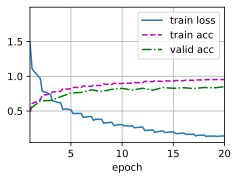

In [12]:
devices, num_epochs, lr, wd = d2l.try_all_gpus(), 20, 2e-4, 5e-4
lr_period, lr_decay, net = 4, 0.9, get_net()
train(net, train_iter, valid_iter, num_epochs, lr, wd, devices, lr_period, lr_decay)

In [13]:
# # 释放显存
# from numba import cuda
# cuda.select_device(0)
# cuda.close()

对测试集进行分类并提交结果

KeyboardInterrupt: 

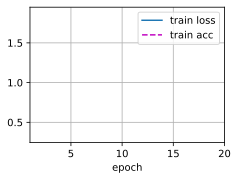

In [19]:
devices, num_epochs, lr, wd = d2l.try_all_gpus(), 20, 2e-4, 5e-4
lr_period, lr_decay, net = 4, 0.9, get_net()

net, preds = get_net(), []
train(net, train_valid_iter, None, num_epochs, lr, wd, devices, lr_period, lr_decay)

for X, _ in test_iter:
    y_hat = net(X.to(devices[0]))
    preds.extend(y_hat.argmax(dim=1).type(torch.int32).cpu().numpy())
sorted_ids = list(range(1, len(test_ds) + 1)) # 生成对应的id
sorted_ids.sort(key=lambda x: str(x)) # 将id转换为字符串，然后排序，注意：这里不是按数字排的序，而是按转换后的字符串排的序
df = pd.DataFrame({'id': sorted_ids, 'label': preds}) # 转换成pandas的DF格式

# .apply()函数：遍历DataFrame的元素（一行数据或者一列数据），默认列遍历
# ImageFolder返回对象的.classes属性：用一个 list 保存类别名称
# 这个的作用是：模型预测出来是概率最大的那个数的下标，在保存文件时，需要把数字类别转换为字符串类别，
# train_valid_ds.classes就是获取字符串类别名（返回的是一个列表），然后使用apply一行一行读取出来，把数字类别转换为字符串类别
df['label'] = df['label'].apply(lambda x: train_valid_ds.classes[x]) 
df.to_csv('submission.csv', index=False)

In [20]:
train_valid_ds.classes

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']